# Full FFT implementation

Based on the procedure from Meyer-Baese 2014 (decimation by frequency with bit-reversed outputs).

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import display, Image

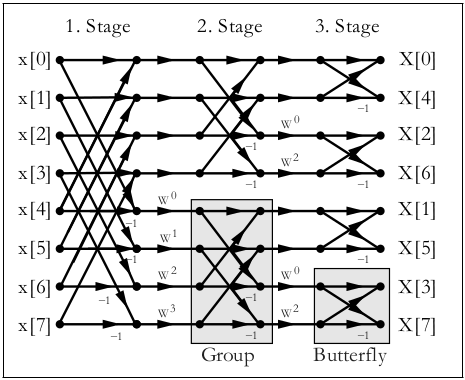

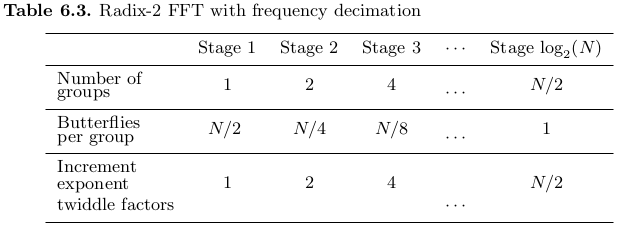

In [2]:
display(Image("img/baese_figure_6_13.png"))
display(Image("img/baese_table_6_3.png", width=500))

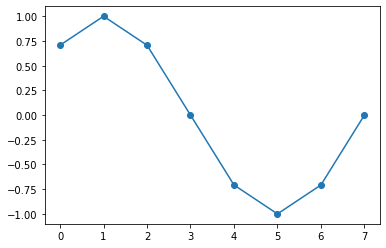

In [3]:
N = 8
log2_N = int(np.log(N)/np.log(2))
n = np.arange(N)

# Test sequence
x = np.sin(2*np.pi*(n + N//8)/N)

fig, ax = plt.subplots()
ax.plot(n, x, "o-")
pass

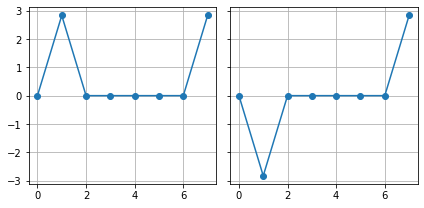

In [4]:
def show(X, color="C0"):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
    ax1.plot(np.real(X), "o-", color=color)
    ax2.plot(np.imag(X), "o-", color=color)
    for ax in (ax1, ax2):
        ax.grid(True)
    fig.tight_layout()
    
# Reference result
X_ref = np.fft.fft(x)
show(X_ref)

In [5]:
def index_generator(N):
    # From Meyer-Baese 2014, page 446
    log2_N = int(np.log(N)/np.log(2))
    stage = 1
    gcount = 0
    i1 = 0
    i2 = N//2
    k1 = N
    k2 = N//2
    w = 0
    dw = 1

    while True:
        # print(f"{stage=} {gcount=} {i1=} {i2=} {k1=} {k2=} {w=} {dw=}")
        yield i1, i2, w
        
        i1 = i1 + k1 # Next bufferfly in group
        i2 = i1 + k2

        if i1 >= N-1: # All butterfiles in group done?
            gcount = gcount + 1
            i1 = gcount
            i2 = i1 + k2
            if gcount >= k2: # All groups done in stage?
                gcount = 0
                i1 = 0
                i2 = k2
                dw = 2*dw
                stage = stage + 1
                if stage > log2_N: # All stages done?
                    break
                else: # Start new stage
                    k1 = k2
                    k2 = k2//2
                    i1 = 0
                    i2 = k2
                    w = 0
            else: # Start new group
                i1 = gcount
                i2 = i1 + k2
                w = w + dw


def butterfly(a, b, w):
    return (a+b), (a-b)*w

def bitreverse(n):
    fmt = "{:0%sb}" % log2_N
    s = fmt.format(n)
    return int(s[::-1], 2)

SUCCESS: The output matches the reference


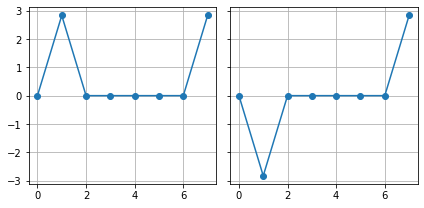

In [6]:
# Twiddle factors and memory line
W = np.exp(-2j*np.pi/N)**n
X = np.zeros(N, dtype=complex)

# Load data (or we could simply overwrite `x`)
X = x.copy().astype(complex)

# Iterate through all butterflies
for i1, i2, w in index_generator(N):
    X[i1], X[i2] = butterfly(X[i1], X[i2], W[w])

# Ouput the bit-reversed indexes
X = X[[bitreverse(n) for n in range(N)]]

# Check the output
if all(np.isclose(X_ref, X)):
    print("SUCCESS: The output matches the reference")
else:
    print("ERROR: The output does not match the reference")
show(X)